In [11]:
import os, sys

current_dir = os.getcwd()

target_folder = 'polygraphs'

target_path = current_dir[:current_dir.index(target_folder) + len(target_folder)]
sys.path.append(target_path)

In [12]:
from polygraphs.analysis import Processor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest

import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [13]:
processor = Processor(["~/polygraphs-cache/results/"], config_check=False)
processor.add_config("reliability")

In [14]:
# Collect Belief Data
beliefs = pd.DataFrame()

for sim in processor.sims.iterrows():
    _ = processor.beliefs[sim[0]].copy()
    _["sim"] = sim[0]
    _["op"] = sim[1].op
    _["reliability"] = sim[1].reliability
    beliefs = pd.concat([beliefs, _])

blfs = beliefs.copy()

In [15]:
# Aggregate Beliefs at Graph Level 
aggregated_beliefs = (
    beliefs.groupby(["op", "iteration"])
    .agg(
        mean_beliefs=("beliefs", "mean"),
        median_beliefs=("beliefs", "median"),
        std_beliefs=("beliefs", "std"),
        min_beliefs=("beliefs", "min"),
        max_beliefs=("beliefs", "max"),
        p25_beliefs=("beliefs", lambda x: x.quantile(0.25)),
        p75_beliefs=("beliefs", lambda x: x.quantile(0.75))
    )
    .reset_index()
)

In [16]:
aggregated_beliefs

,op,iteration,mean_beliefs,median_beliefs,std_beliefs,min_beliefs,max_beliefs,p25_beliefs,p75_beliefs
0,BalaGoyalOp,0,0.499112,0.498167,0.289292,0.000005,0.999994,0.248027,0.750531
1,BalaGoyalOp,1,0.499647,0.49885,0.289438,0.000005,0.999994,0.248377,0.751215
2,BalaGoyalOp,100,0.554684,0.583315,0.305598,0.000002,0.999999,0.287227,0.835387
3,BalaGoyalOp,200,0.61072,0.675926,0.314457,0.000001,1.0,0.340673,0.904614
4,BalaGoyalOp,300,0.660106,0.762326,0.31689,0.0,1.0,0.402658,0.950697
...,...,...,...,...,...,...,...,...,...
1507,UnreliableNetworkModifiedAlignedNegativeEpsOp,24600,0.908092,0.999999,0.256325,0.0,1.0,0.999843,1.0
1508,UnreliableNetworkModifiedAlignedNegativeEpsOp,24700,0.90824,0.999999,0.256129,0.0,1.0,0.999845,1.0
1509,UnreliableNetworkModifiedAlignedNegativeEpsOp,24800,0.90778,0.999999,0.256638,0.0,1.0,0.99984,1.0
1510,UnreliableNetworkModifiedAlignedNegativeEpsOp,24900,0.908298,0.999999,0.256058,0.0,1.0,0.999854,1.0


## ANOVA Test

#### Hypotheses

- Null Hypothesis: \( H_0 \): There is no significant difference in mean credence across operators.
- Alternative Hypothesis: \( H_a \): There is a significant difference in mean credence across operators.

In [17]:
# Group data by 'op' and collect mean beliefs
grouped = aggregated_beliefs.groupby('op')['mean_beliefs'].apply(list).reset_index()

# Perform ANOVA test
anova_result = stats.f_oneway(*grouped['mean_beliefs'])
print(f"ANOVA Test: F-statistic = {anova_result.statistic}, p-value = {anova_result.pvalue}")

ANOVA Test: F-statistic = 97.20475289920871, p-value = 6.453413080735455e-89


Reject the null hypothesis.

## Tukey's HSD Test

Let's compare all pairs of groups to find where the differences lie.

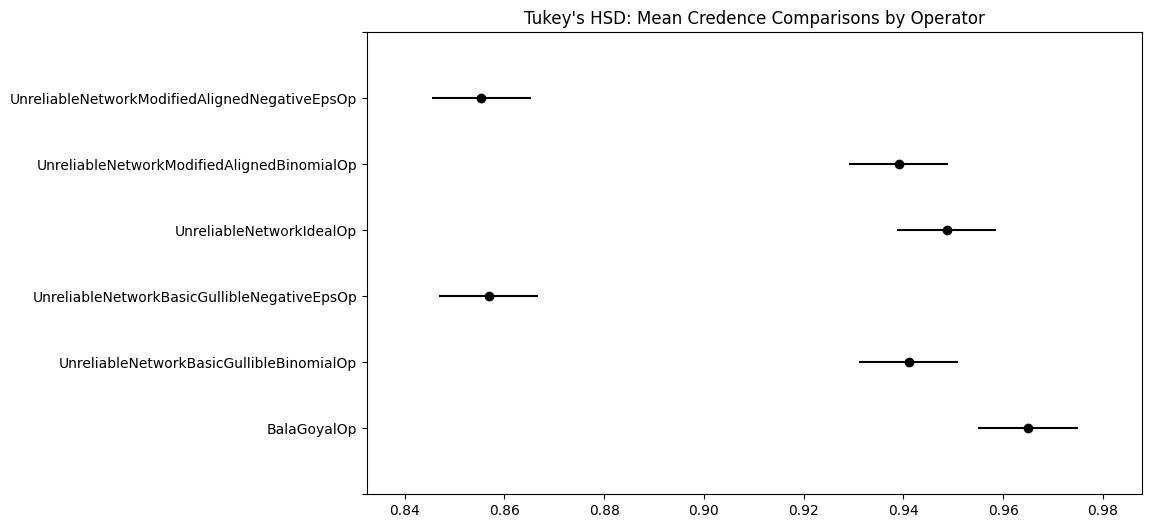

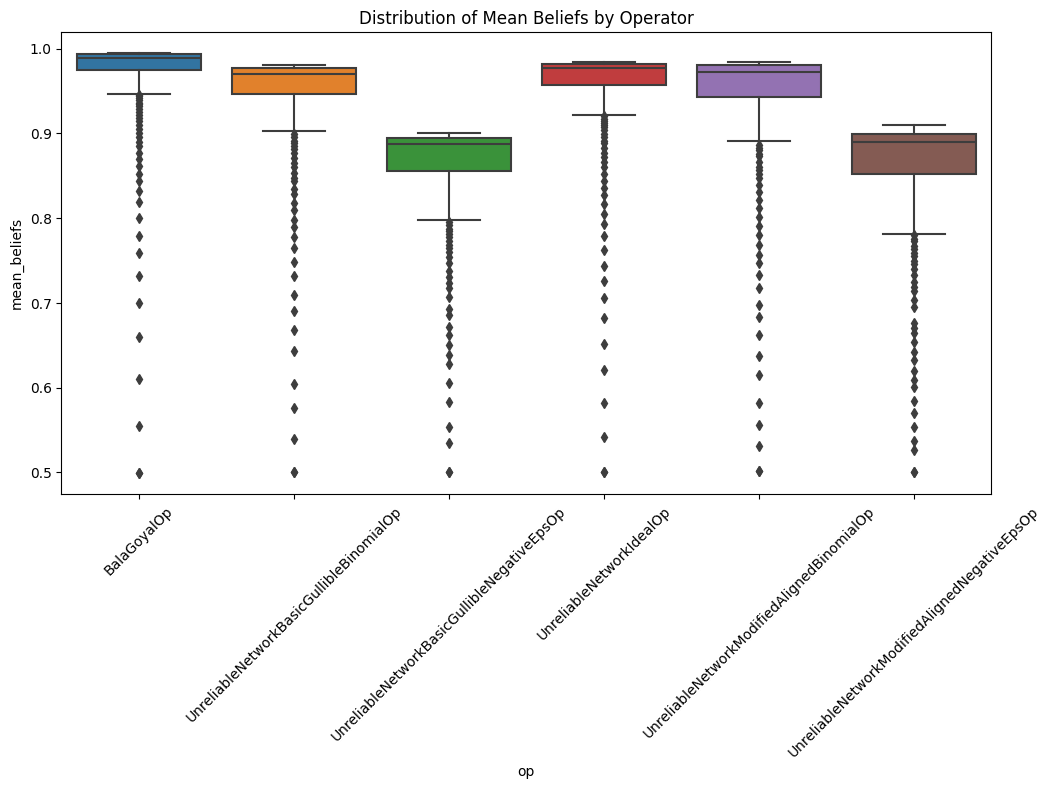

In [23]:
# Tukey's HSD Test
tukey_data = aggregated_beliefs[['op', 'mean_beliefs']].dropna()

tukey = pairwise_tukeyhsd(
    endog=tukey_data['mean_beliefs'],
    groups=tukey_data['op'],
    alpha=0.05
)

# Convert the results to a DataFrame
tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

# Visualize Pairwise Comparisons
fig = tukey.plot_simultaneous()
plt.title("Tukey's HSD: Mean Credence Comparisons by Operator")
plt.show()

# Boxplot Visualization
plt.figure(figsize=(12, 6))
sns.boxplot(x='op', y='mean_beliefs', data=aggregated_beliefs)
plt.title('Distribution of Mean Beliefs by Operator')
plt.xticks(rotation=45)
plt.show()


In [24]:
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,BalaGoyalOp,UnreliableNetworkBasicGullibleBinomialOp,-0.0239,0.0082,-0.0437,-0.0040,True
1,BalaGoyalOp,UnreliableNetworkBasicGullibleNegativeEpsOp,-0.1081,0.0000,-0.1279,-0.0882,True
2,BalaGoyalOp,UnreliableNetworkIdealOp,-0.0162,0.1814,-0.0361,0.0036,False
3,BalaGoyalOp,UnreliableNetworkModifiedAlignedBinomialOp,-0.0259,0.0029,-0.0457,-0.0060,True
4,BalaGoyalOp,UnreliableNetworkModifiedAlignedNegativeEpsOp,-0.1096,0.0000,-0.1295,-0.0897,True
5,UnreliableNetworkBasicGullibleBinomialOp,UnreliableNetworkBasicGullibleNegativeEpsOp,-0.0842,0.0000,-0.1041,-0.0643,True
6,UnreliableNetworkBasicGullibleBinomialOp,UnreliableNetworkIdealOp,0.0076,0.8841,-0.0123,0.0275,False
7,UnreliableNetworkBasicGullibleBinomialOp,UnreliableNetworkModifiedAlignedBinomialOp,-0.0020,0.9997,-0.0219,0.0179,False
8,UnreliableNetworkBasicGullibleBinomialOp,UnreliableNetworkModifiedAlignedNegativeEpsOp,-0.0857,0.0000,-0.1056,-0.0659,True
9,UnreliableNetworkBasicGullibleNegativeEpsOp,UnreliableNetworkIdealOp,0.0918,0.0000,0.0719,0.1117,True


## Kolmogorov-Smirnov Test

Pairwise comparisons of distributions for each op.

In [19]:
# Pairwise KS Test
print("\nKolmogorov-Smirnov Test Results:")
for i, op1 in enumerate(grouped['op']):
    for j, op2 in enumerate(grouped['op']):
        if i < j:
            ks_stat, p_value = kstest(grouped.loc[i, 'mean_beliefs'], grouped.loc[j, 'mean_beliefs'])
            print(f"{op1} vs {op2}: KS-statistic = {ks_stat}, p-value = {p_value}")


Kolmogorov-Smirnov Test Results:
BalaGoyalOp vs UnreliableNetworkBasicGullibleBinomialOp: KS-statistic = 0.6825396825396826, p-value = 3.108153803200769e-56
BalaGoyalOp vs UnreliableNetworkBasicGullibleNegativeEpsOp: KS-statistic = 0.9206349206349206, p-value = 3.3729780058779814e-115
BalaGoyalOp vs UnreliableNetworkIdealOp: KS-statistic = 0.6349206349206349, p-value = 5.159806972040643e-48
BalaGoyalOp vs UnreliableNetworkModifiedAlignedBinomialOp: KS-statistic = 0.626984126984127, p-value = 9.994514232321966e-47
BalaGoyalOp vs UnreliableNetworkModifiedAlignedNegativeEpsOp: KS-statistic = 0.9126984126984127, p-value = 1.7067268709742586e-112
UnreliableNetworkBasicGullibleBinomialOp vs UnreliableNetworkBasicGullibleNegativeEpsOp: KS-statistic = 0.873015873015873, p-value = 4.4917342878221054e-100
UnreliableNetworkBasicGullibleBinomialOp vs UnreliableNetworkIdealOp: KS-statistic = 0.36507936507936506, p-value = 2.527075621186129e-15
UnreliableNetworkBasicGullibleBinomialOp vs Unreliable

## Average belief under each operation at steps 5k, 10k, 15k, 20k, and 25k

In [20]:
blfs

beliefs  sim                                           op  \
iteration node                                                                
0         0      0.947176    0                     UnreliableNetworkIdealOp   
          1      0.247688    0                     UnreliableNetworkIdealOp   
          2      0.529837    0                     UnreliableNetworkIdealOp   
          3      0.838908    0                     UnreliableNetworkIdealOp   
          4       0.96534    0                     UnreliableNetworkIdealOp   
...                   ...  ...                                          ...   
25000     13027  0.999999   59  UnreliableNetworkBasicGullibleNegativeEpsOp   
          13028  0.999999   59  UnreliableNetworkBasicGullibleNegativeEpsOp   
          13029  0.999999   59  UnreliableNetworkBasicGullibleNegativeEpsOp   
          13030  0.999822   59  UnreliableNetworkBasicGullibleNegativeEpsOp   
          13031  0.999947   59  UnreliableNetworkBasicGullibleNegativeEpsOp   

                 reliability  
iteration node                
0         0             0.75  
          1             0.75  
          2             0.75  
          3             0.75  
          4             0.75  
...                      ...  
25000     13027         0.75  
          13028         0.75  
          13029         0.75  
          13030         0.75  
          13031         0.75  

[197043840 rows x 4 columns]

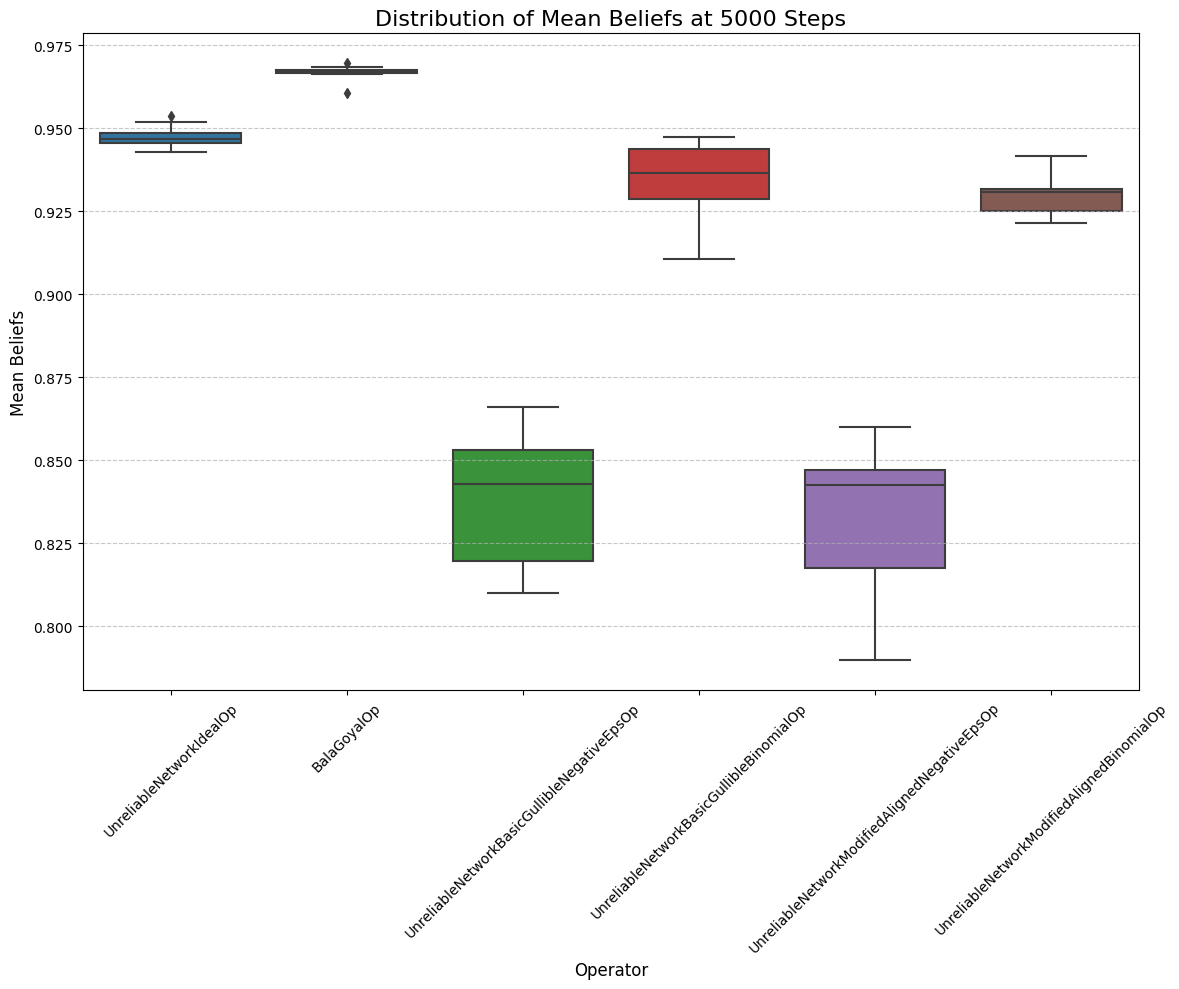

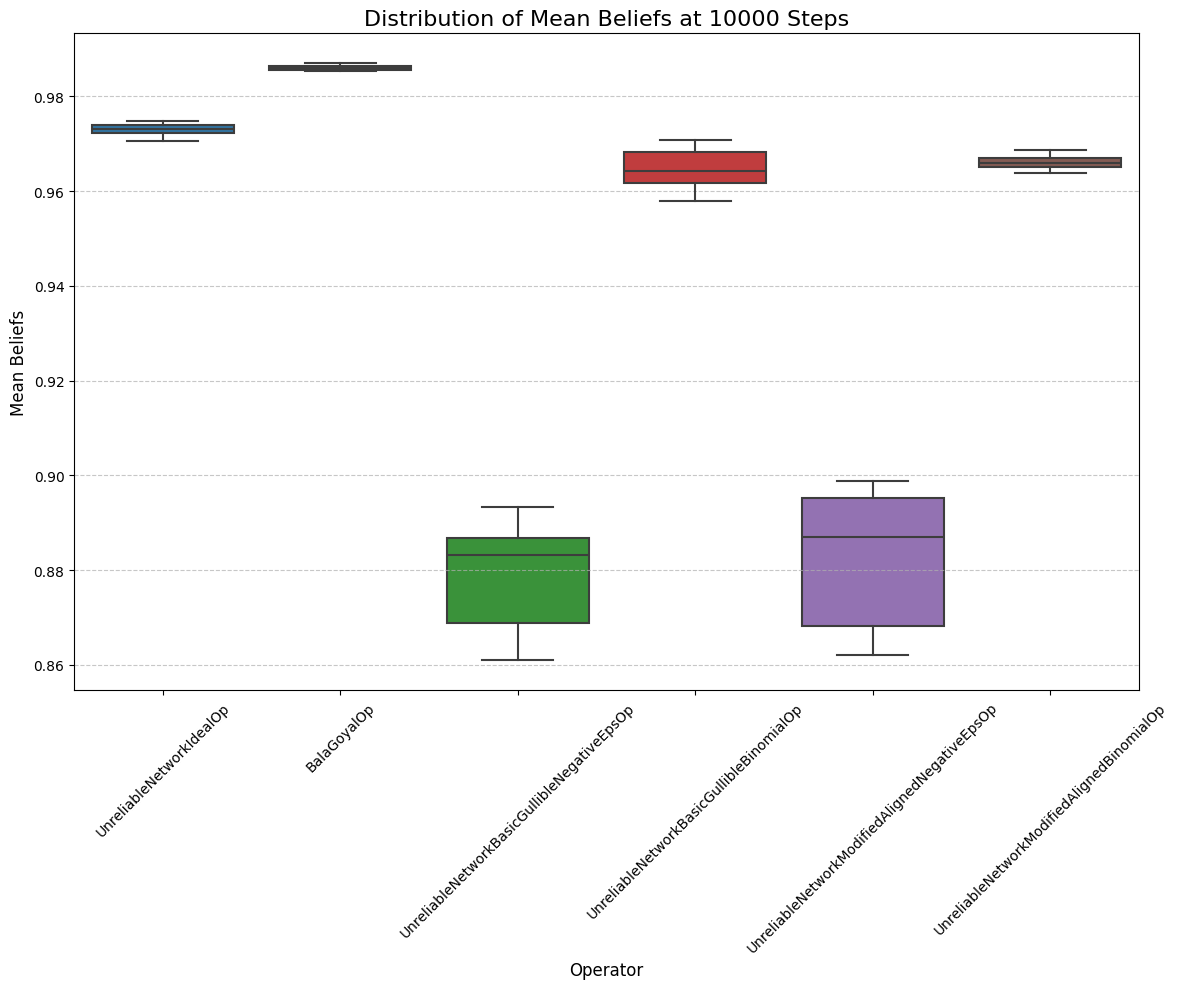

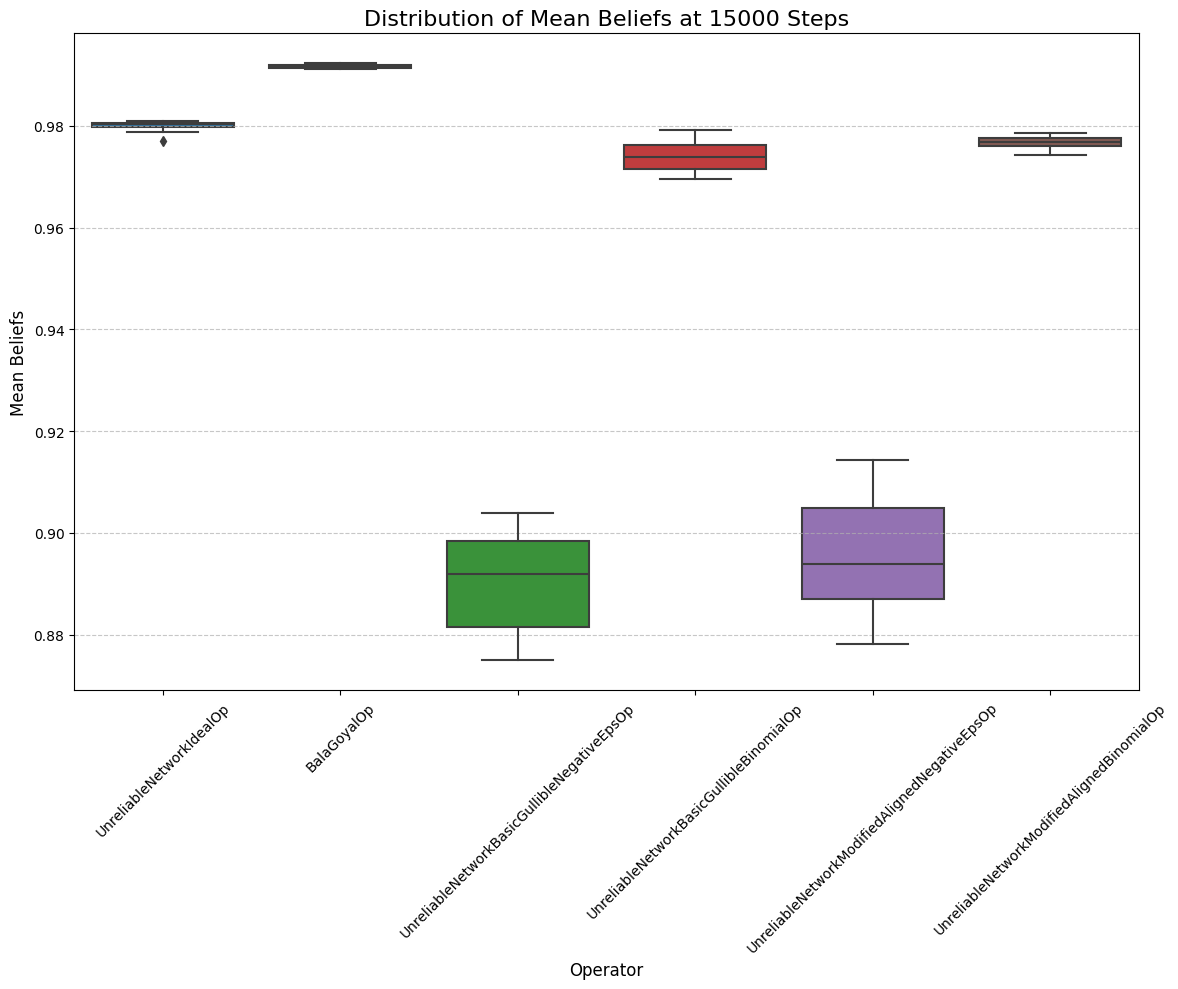

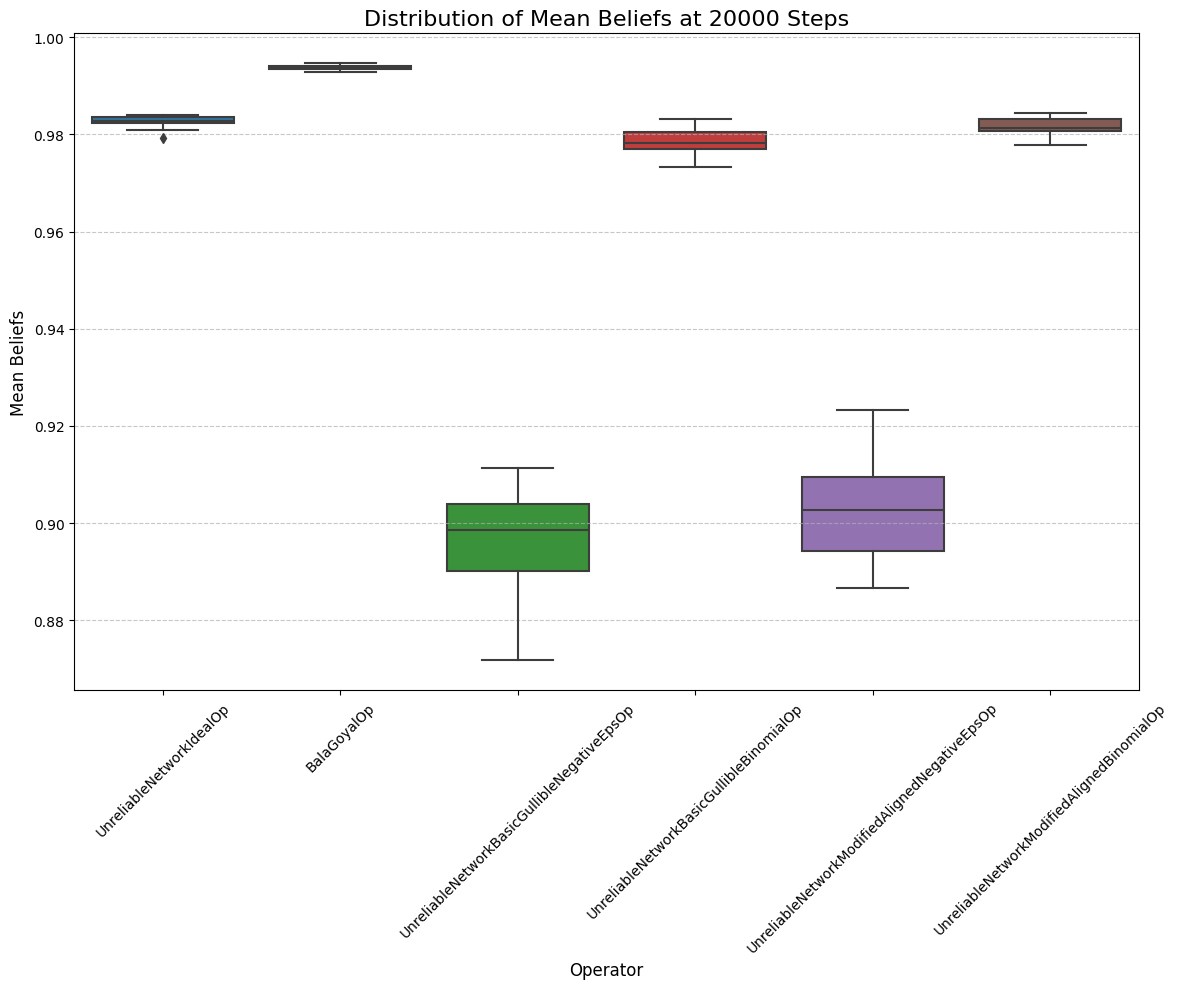

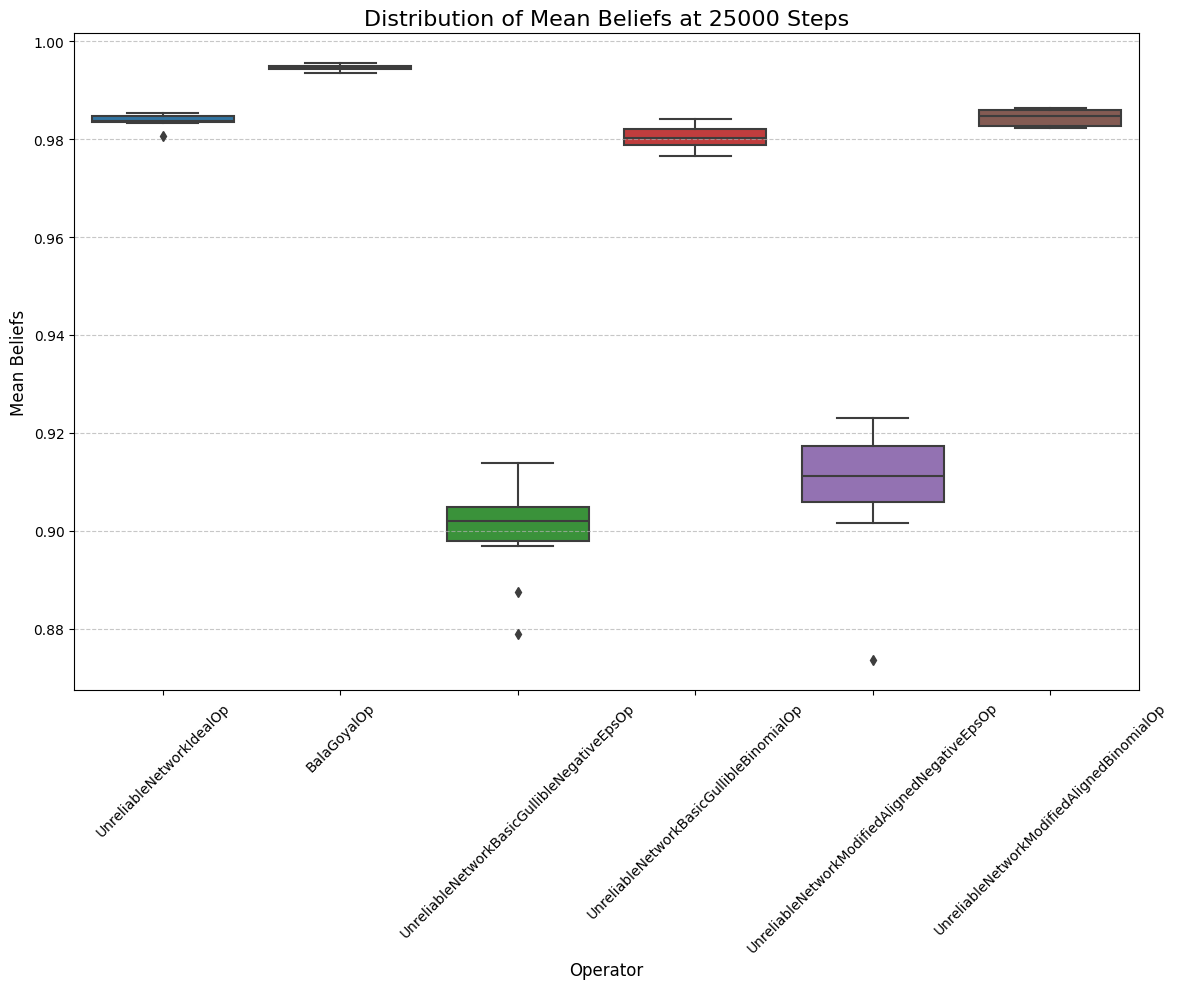

In [22]:
# Ensure 'iteration' is in columns
if 'iteration' not in blfs.columns:
    if isinstance(blfs.index, pd.MultiIndex):
        # Extract 'iteration' from MultiIndex if available
        blfs = blfs.reset_index()
    else:
        # Create a synthetic 'iteration' based on row indices
        blfs['iteration'] = blfs.index

# Specify snapshot iterations
snapshot_iterations = [5000, 10000, 15000, 20000, 25000]

# Filter beliefs for the specific snapshot iterations
filtered_beliefs = blfs[blfs['iteration'].isin(snapshot_iterations)]

# Calculate the average belief for each simulation at each snapshot iteration
avg_beliefs = filtered_beliefs.groupby(['sim', 'iteration', 'op'])['beliefs'].mean().reset_index()

# Create a boxplot for each snapshot iteration
for iteration in snapshot_iterations:
    plt.figure(figsize=(12, 10))

    # Filter data for the current snapshot iteration
    current_data = avg_beliefs[avg_beliefs['iteration'] == iteration]
    
    # Create a boxplot for the current iteration showing all operators
    sns.boxplot(
        data=current_data,
        x="op",
        y="beliefs",
        palette="tab10"
    )
    
    plt.title(f"Distribution of Mean Beliefs at {iteration} Steps", fontsize=16)
    plt.xlabel("Operator", fontsize=12)
    plt.ylabel("Mean Beliefs", fontsize=12)
    plt.xticks(rotation=45)  # Rotate x labels for clarity
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    # Save the plot
    plt.savefig(f"images/mean_beliefs_operator_{iteration}.png", format="png", dpi=300, bbox_inches="tight")
    plt.savefig(f"images/mean_beliefs_operator_{iteration}.svg", format="svg", bbox_inches="tight")
    
    # Show the plot
    plt.show()
